In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from src.models.rae_words import RAEWords as RAE
from src.models.vrae_words import VRAEWords as VRAE
from src.models.iaf_words import IAFWords as IAF

from src.models.vrae_chars import VariationalInference

from src.data.toy import ToyData, Continuous
from src.data.common import get_loader
from src.models.common import CriterionTrainer, OneHotPacked, VITrainer

from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss

import numpy as np

seed = 42
torch.set_deterministic(True)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Defining data

In [2]:
data_parameters = {
    "max_length" : 30,
    "min_length" : 2,
    "error_scale" : 0.02,
}

batch_size = 100
max_epochs = 50

train_data = Continuous(num_observations=10_000, **data_parameters)
validation_data = Continuous(num_observations=1_000, **data_parameters)
test_data = Continuous(num_observations=1_000, **data_parameters)

# Recurrent autoencoder

In [3]:
rae = RAE(
    input_dim=1,
    latent_features=2,
    encoder_hidden_size=32,
    decoder_hidden_size=32,
)

optimizer_parameters = {
    "lr": 0.01,
}

criterion = MSELoss(reduction="sum")
optimizer = Adam(rae.parameters(), **optimizer_parameters)

class CriterionTrainerNoCache(CriterionTrainer):

    def save_checkpoint(self):
        pass

    def restore_checkpoint(self):
        pass

mt = CriterionTrainerNoCache(
    criterion=criterion,
    model=rae,
    optimizer=optimizer,
    batch_size=batch_size,
    max_epochs=max_epochs,
    training_data=train_data,
    validation_data=test_data,
)

mt.train(progress_bar=True)

Training using CPU
Epoch 1 done!
T. loss: 3.2954408979415892
V. loss: 8.031733465194701


In [32]:
num_tests = 1000
x_test = next(iter(get_loader(test_data, batch_size=num_tests)))

output_rae = rae(x_test)

# Sample from observation model and pack, then pad
sample_rae_padded, sequence_lengths = pad_packed_sequence(output_rae)
sample_rae_padded = sample_rae_padded

target_padded, _ = pad_packed_sequence(x_test)

for i, length, _ in zip(range(num_tests), sequence_lengths, range(3)):

    decoded_rae = sample_rae_padded[:, i][:length]
    target = target_padded[:, i][:length]

    print("RAE:")
    print(decoded_rae)
    print("TARGET:")
    print(target)

    print("")

RAE:
tensor([[ 0.8520],
        [ 0.9040],
        [ 0.9231],
        [ 0.9508],
        [ 0.9773],
        [ 0.9894],
        [ 0.9985],
        [ 1.0002],
        [ 0.9988],
        [ 0.9940],
        [ 0.9875],
        [ 0.9799],
        [ 0.9717],
        [ 0.9638],
        [ 0.9565],
        [ 0.9504],
        [ 0.9457],
        [ 0.9429],
        [ 0.9420],
        [ 0.9431],
        [ 0.9460],
        [ 0.9503],
        [ 0.9555],
        [ 0.9603],
        [ 0.9632],
        [ 0.9616],
        [ 0.9535],
        [ 0.9469],
        [ 0.9790],
        [ 0.9603],
        [-0.9419]], grad_fn=<SliceBackward>)
TARGET:
tensor([[ 0.9905],
        [ 1.0025],
        [ 0.9770],
        [ 0.9586],
        [ 0.9860],
        [ 0.9928],
        [ 0.9801],
        [ 0.9944],
        [ 0.9890],
        [ 0.9479],
        [ 0.9632],
        [ 0.9733],
        [ 0.9824],
        [ 0.9933],
        [ 0.9708],
        [ 0.9297],
        [ 0.9596],
        [ 0.9793],
        [ 0.9891],
        [ 0

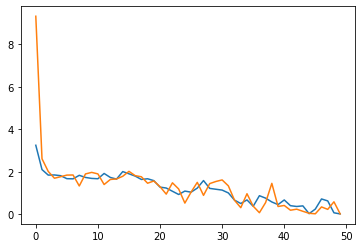

In [12]:
import matplotlib.pyplot as plt
plt.plot(mt.training_loss)
plt.plot(mt.validation_loss)

<AxesSubplot:>

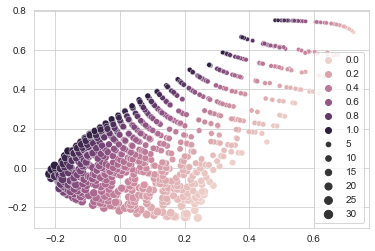

In [29]:
import seaborn as sns

sns.set_style("whitegrid")

x, y = rae.encoder(x_test).detach().squeeze().numpy().T

lengths = sequence_lengths.squeeze().numpy()
target_averages = []

for i, length in enumerate(lengths):
    arr = target_padded[:,i][:length-1].numpy()
    target_averages.append(arr.mean())

data = {
    'x' : x,
    'y' : y,
    'length' : lengths,
    'average' : target_averages,
}

sns.scatterplot(
    x=data['x'], 
    y=data['y'], 
    size=data['length'], 
    hue=data['average']
    )

# Variational recurrent autoencoder

In [3]:
vrae = VRAE(
    input_dim=1,
    latent_features=2,
    encoder_hidden_size=32,
    decoder_hidden_size=32,
)

optimizer_parameters = {
    "lr": 0.01,
}

vi = VariationalInference()
optimizer = Adam(vrae.parameters(), **optimizer_parameters)

class VITrainerNoCache(VITrainer):

    def save_checkpoint(self):
        pass

    def restore_checkpoint(self):
        pass

mt = VITrainerNoCache(
    vi=vi,
    model=vrae,
    optimizer=optimizer,
    batch_size=batch_size,
    max_epochs=max_epochs,
    training_data=train_data,
    validation_data=test_data,
)

mt.train(progress_bar='epoch')

Training using CPU
100%|██████████| 50/50 [04:47<00:00,  5.75s/it, T. loss:=-8.52, V. loss:=6.92]


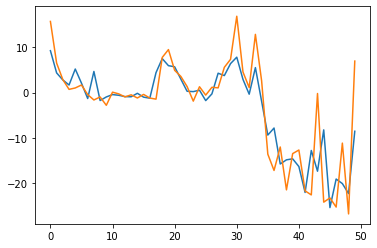

In [5]:
import matplotlib.pyplot as plt
plt.plot(mt.training_loss)
plt.plot(mt.validation_loss)

In [15]:
num_tests = 1000
x_test = next(iter(get_loader(test_data, batch_size=num_tests)))

output_vrae = vrae(x_test)

# Sample from observation model and pack, then pad
sample_vrae_packed = PackedSequence(
    output_vrae['px'].sample(),
    x_test.batch_sizes

)
sample_vrae_padded, sequence_lengths = pad_packed_sequence(sample_vrae_packed)

target_padded, _ = pad_packed_sequence(x_test)

for i, length, _ in zip(range(num_tests), sequence_lengths, range(16)):

    decoded_vrae = sample_vrae_padded[:, i][:length]
    target = target_padded[:, i][:length]

    print(decoded_vrae)
    print("")

tensor([[ 0.5687],
        [ 0.5517],
        [ 0.5782],
        [ 0.5159],
        [ 0.5507],
        [ 0.5555],
        [ 0.5636],
        [ 0.5189],
        [ 0.5958],
        [ 0.5810],
        [ 0.5521],
        [ 0.5272],
        [ 0.5552],
        [ 0.5762],
        [ 0.5585],
        [ 0.5647],
        [ 0.5539],
        [ 0.5709],
        [ 0.6066],
        [ 0.5839],
        [ 0.5939],
        [ 0.5142],
        [ 0.5813],
        [-0.0640],
        [ 0.0085],
        [ 1.2136],
        [-0.1291],
        [ 0.5209],
        [ 0.6142],
        [ 0.4711],
        [ 0.5087]])

tensor([[ 0.7163],
        [ 0.6919],
        [ 0.6934],
        [ 0.6933],
        [ 0.7007],
        [ 0.6840],
        [ 0.7164],
        [ 0.7183],
        [ 0.6749],
        [ 0.6988],
        [ 0.7158],
        [ 0.6957],
        [ 0.6567],
        [ 0.6734],
        [ 0.6914],
        [ 0.7175],
        [ 0.6702],
        [ 0.7250],
        [ 0.7035],
        [ 0.7144],
        [ 0.6951],
        [ 

In [16]:
vrae(x_test)

In [17]:
mu, log_sigma = vrae.encoder(x_test)
mu = mu.detach().numpy()

<AxesSubplot:>

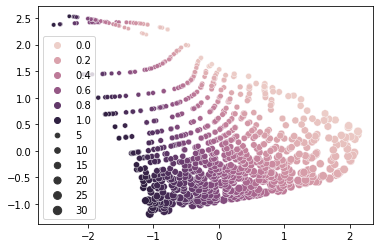

In [18]:
import seaborn as sns

x, y = mu.T

lengths = sequence_lengths.squeeze().numpy()
target_averages = []

for i, length in enumerate(lengths):
    arr = target_padded[:,i][:length-1].numpy()
    target_averages.append(arr.mean())

data = {
    'x' : x,
    'y' : y,
    'length' : lengths,
    'value' : target_averages,
}

sns.scatterplot(
    x=data['x'], 
    y=data['y'], 
    size=data['length'], 
    hue=data['value']
    )

In [12]:
import seaborn as sns

sns.set_style("whitegrid")

x, y = rae.encoder(x_test).detach().squeeze().numpy().T

lengths = sequence_lengths.squeeze().numpy()
target_averages = []

for i, length in enumerate(lengths):
    arr = target_padded[:,i][:length-1].numpy()
    target_averages.append(arr.mean())

data = {
    'x' : x,
    'y' : y,
    'length' : lengths,
    'average' : target_averages,
}

sns.scatterplot(
    x=data['x'], 
    y=data['y'], 
    size=data['length'], 
    hue=data['average']
    )

tensor([[0., 0., 0., 0.]])